###**0. Imports e connect à Google Drive**

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# este comando é usado para mudar a diretória atual para o dataset
%cd /content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset


##**Usa-se o X_test para avaliar o modelo final, que possui imagens com e sem a sample**

In [4]:
def number_of_images(X_type):

    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_images'
    files = os.listdir(root)

    return len(files)

In [5]:
number_of_images('test')

2884

In [6]:
def create_X_set_normalized(X_type):

    X_set = []
    root = './organized_data_gray/' + X_type + '/X_' + X_type + '_images'
    length = number_of_images(X_type)

    for i in range(0, length):

      try:
        path = root + '/processed_' + X_type + 'image_' + str(i) + '.png'
        arr3 = cv2.imread(path)
        img_arr, _, _ = cv2.split(arr3)
        img_arr = cv2.resize(img_arr,(512,360))
        img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        X_set.append(img_normalized)

      except ValueError:
        pass

    return np.array(X_set)

In [7]:
X_test = create_X_set_normalized('test')

In [8]:
X_test.shape

(2884, 360, 512)

##**Preparar o y_test_regression e y_test_detection**

**y_test_regression são as coordenadas das bounding boxes e y_test_detection é basicamente o One-hot Encoding para 0 e 1 (0 é representado por [1,0] e 1 por [0,1])**

In [9]:
df_ytest = pd.read_csv('./organized_data_gray/test/y_test.csv')

In [10]:
def prepare_y_set_regression(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [11]:
y_test_regression = prepare_y_set_regression(df_ytest)

In [12]:
y_test_regression[:2]

array([[0.98698566, 0.15853659, 0.02244389, 0.02217295],
       [0.97950436, 0.154102  , 0.02078138, 0.02660754]])

In [13]:
y_test_regression.shape

(2884, 4)

In [14]:
def prepare_y_set_detection(y_set):

    y = []
    for bbox in y_set:

        if np.isnan(bbox[0]):
          y.append([1,0])  # [1,0] representa 0, ou seja, o tubo não está presente

        else:
          y.append([0,1])

    return np.array(y)

In [15]:
y_test_detection = prepare_y_set_detection(y_test_regression)

In [16]:
y_test_detection[:2]

array([[0, 1],
       [0, 1]])

In [17]:
y_test_detection.shape

(2884, 2)

##**Preparar o y_val_01, que é a "tradução" do y_val_detection para 0's e 1's**

In [18]:
# esta função fornece um entendimento direto do conjunto y em causa:
# se o elemento é 0, não há sample na imagem
# se o elemento é 1, a sample está na imagem

def zeros_and_ones(y_set):

    y_zeros_ones = []

    for y in y_set:

      if y[0] == 1:
        y_zeros_ones.append(0)

      else:
        y_zeros_ones.append(1)

    return np.array(y_zeros_ones)

In [19]:
y_test_01 = zeros_and_ones(y_test_detection)

In [20]:
print(X_test.shape, y_test_01.shape, y_test_detection.shape, y_test_regression.shape)

(2884, 360, 512) (2884,) (2884, 2) (2884, 4)


##**Arquitetura dos dois modelos**

In [21]:
model_detection = Sequential([

    Conv2D(filters=64, kernel_size=(3,3), input_shape=(360, 512, 1), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),

    Dense(2, activation='softmax')
])

model_detection.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 358, 510, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 179, 255, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 179, 255, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 177, 253, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 88, 126, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 88, 126, 32)       0

In [22]:
model_regression = Sequential([

    Conv2D(filters=16,kernel_size=(3,3), input_shape = (384, 512, 1), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),

    Dense(4, activation='sigmoid')
])

model_regression.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 382, 510, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 191, 255, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 94, 126, 32)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 94, 126, 32)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 92, 124, 64)      

###**Fazer a pipeline de predictions com ambos os modelos:**

In [23]:
model_detection.load_weights('./callbacks/checkpoints/grayCkpt1_13_0.68606_ .h5')
model_regression.load_weights('./callbacks/checkpoints/grayCkpt1_17_0.00889_.h5')

In [24]:
def show_image_bbox(X_arr, y_arr, confidence, new_img_path):

  y_arr_albu = [0,0,0,0]

  if len(y_arr) != 0:
    y_arr_albu[0] = y_arr[0] - y_arr[2] / 2
    y_arr_albu[1] = y_arr[1] - y_arr[3] / 2
    y_arr_albu[2] = y_arr[2] + y_arr_albu[0]
    y_arr_albu[3] = y_arr[3] + y_arr_albu[1]


  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  X_arr = cv2.merge([X_arr, X_arr, X_arr])

  bbox_ = copy.deepcopy(y_arr_albu)
  pil_img = tf.keras.utils.array_to_img(X_arr)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    image = cv2.putText(image, 'sample ' + str(confidence), (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

In [25]:
def bboxYOLO_to_Albu(y_set):

    y_Albu = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = bbox[0] - bbox[2] / 2
        vector[1] = bbox[1] - bbox[3] / 2
        vector[2] = bbox[2] + vector[0]
        vector[3] = bbox[3] + vector[1]

        y_Albu.append(vector)

    return np.array(y_Albu)

In [96]:
def intersection_over_union(bboxA, bboxB):

    if np.isnan(bboxA[0]) or np.isnan(bboxB[0]):

      return 1

    bboxes = bboxYOLO_to_Albu([bboxA, bboxB])
    bbox1 = bboxes[0]
    bbox2 = bboxes[1]

    # bbox = [xmin, ymin, xmax, ymax]
    xmin = max(bbox1[0], bbox2[0])
    ymin = max(bbox1[1], bbox2[1])
    xmax = min(bbox1[2], bbox2[2])
    ymax = min(bbox1[3], bbox2[3])

    intersection_width = xmax - xmin
    intersection_height = ymax - ymin

    if intersection_width <= 0 or intersection_height <= 0:
      return 0

    intersection_area = intersection_width * intersection_height

    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = bbox1_area + bbox2_area - intersection_area

    IoU = round(intersection_area / union_area, 2)

    return IoU

In [27]:
def iou_info(y_set, y_pred):

  iou_sum = 0
  iou_above_threshold = []

  threshold = 0

  for i in range(len(y_set)):
      iou = intersection_over_union(y_set[i], y_pred[i])

      if iou > 0:
        iou_above_threshold.append(i)
        iou_sum += iou

  pct_iou_mean = iou_sum / len(iou_above_threshold) * 100
  pct_intersection = len(iou_above_threshold) / y_set.shape[0] * 100

  return pct_iou_mean, len(iou_above_threshold), pct_intersection, iou_above_threshold

In [28]:
def resize_img(X_set):

  X = []
  for arr in X_set:
      X.append(cv2.resize(arr,(512,384)))

  return np.array(X)

In [29]:
X_test.shape

(2884, 360, 512)

In [30]:
y_pred_detection = model_detection.predict(X_test)

91/91 [==============================] - 286s 3s/step


In [31]:
X_test_reshaped = resize_img(X_test)

In [32]:
#X_test = [] para poupar RAM

In [33]:
y_pred_regression = model_regression.predict(X_test_reshaped)

91/91 [==============================] - 156s 2s/step


In [34]:
y_pred_regression.shape, y_test_regression.shape

((2884, 4), (2884, 4))

In [35]:
y_test_regression

array([[0.98698566, 0.15853659, 0.02244389, 0.02217295],
       [0.97950436, 0.154102  , 0.02078138, 0.02660754],
       [0.97410121, 0.15133038, 0.02327515, 0.0210643 ],
       ...,
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]])

In [36]:
y_pred_regression

array([[0.76145613, 0.36077356, 0.09059718, 0.05499758],
       [0.72735184, 0.37649706, 0.11355921, 0.0690549 ],
       [0.6948798 , 0.37916267, 0.12719195, 0.07762206],
       ...,
       [0.58818716, 0.5379398 , 0.15017809, 0.10176861],
       [0.566873  , 0.51565146, 0.18425514, 0.13703543],
       [0.57535875, 0.5040524 , 0.19912064, 0.1527376 ]], dtype=float32)

###**Métricas e resultados**



In [37]:
y_pred_detection[:2]

array([[9.9871880e-01, 1.2812110e-03],
       [9.9922675e-01, 7.7335298e-04]], dtype=float32)

In [121]:
# esta função inicialmente foi feita para criar as linhas da dataframe que se segue,
# tendo sido depois adaptada para ajudar a mostrar a Confusion Matrix em função dos
# inputs; também nos dá os valores dos índices das imagens consideradas
# positivas, tendo em conta apenas o threshold da confidence dado nos inputs da função;
# também retorna as confidence_scores de todos os y_pred_detection

def precision_recall_f1_cm(conf_threshold, iou_threshold):

    y_pred_01 = []
    indexes_positives = []
    confidence_scores = []

    for i, y in enumerate(y_pred_detection):

        confidence = round(y[1], 3)
        confidence_scores.append(confidence)

        if confidence >= conf_threshold:
          y_pred_01.append(1)
          indexes_positives.append(i)

        else:
          y_pred_01.append(0)

    y_pred_01_new = copy.deepcopy(y_pred_01)

    for index in indexes_positives:

        if intersection_over_union(y_pred_regression[index], y_test_regression[index]) < iou_threshold:
          y_pred_01_new[index] = 0


    cm = metrics.confusion_matrix(y_test_01, y_pred_01_new)
    TN, FP, FN, TP = cm.ravel()

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = TP / (TP + 0.5 * (FP + FN))

    lst = [iou_threshold, conf_threshold, precision, recall, f1_score]

    return lst, cm, indexes_positives, confidence_scores

In [127]:
precision_recall_f1_cm(1, 0.0)[0], precision_recall_f1_cm(1, 0.1)[1]

([0.0, 1, 0.7870843989769821, 0.5975728155339806, 0.6793598233995585],
 array([[ 491,  333],
        [1898,  162]]))

In [123]:
precision_recall_f1_cm(0, 0)[0], precision_recall_f1_cm(0, 0)[1]

([0, 0, 0.7142857142857143, 1.0, 0.8333333333333334],
 array([[   0,  824],
        [   0, 2060]]))

In [51]:
conf_thresholds = [round(i * 0.1, 1) for i in range(0,11)]
iou_thresholds = [round(i * 0.1, 1) for i in range(0,6)]
cols = ['iou_threshold', 'confidence_threshold', 'precision', 'recall', 'f1-score']

iou_rows = []
for iou in iou_thresholds:

    iou_rows.extend([precision_recall_f1_cm(conf, iou)[0] for conf in conf_thresholds])

In [52]:
df = pd.DataFrame(iou_rows, columns = cols)
df.set_index(['iou_threshold', 'confidence_threshold'], inplace=True)
df

precision    recall  f1-score
iou_threshold confidence_threshold                               
0.0           0.0                    0.714286  1.000000  0.833333
              0.1                    0.709334  0.874272  0.783214
              0.2                    0.709742  0.866505  0.780328
              0.3                    0.708032  0.855825  0.774945
              0.4                    0.706862  0.845146  0.769843
...                                       ...       ...       ...
0.5           0.6                    0.012676  0.004369  0.006498
              0.7                    0.012857  0.004369  0.006522
              0.8                    0.013100  0.004369  0.006553
              0.9                    0.013575  0.004369  0.006610
              1.0                    0.017699  0.002913  0.005002

[66 rows x 3 columns]

In [53]:
idx = pd.IndexSlice
df0 = df.loc[idx[0, :]]
df1 = df.loc[idx[0.1, :]]
df2 = df.loc[idx[0.2, :]]
df3 = df.loc[idx[0.3, :]]
df4 = df.loc[idx[0.4, :]]
df5 = df.loc[idx[0.5, :]]

df5

,precision,recall,f1-score
confidence_threshold,,,
0.0,0.011990,0.004854,0.006911
0.1,0.012048,0.004369,0.006413
0.2,0.012179,0.004369,0.006431
0.3,0.012228,0.004369,0.006438
0.4,0.012312,0.004369,0.006449
0.5,0.012465,0.004369,0.006470
0.6,0.012676,0.004369,0.006498
0.7,0.012857,0.004369,0.006522
0.8,0.013100,0.004369,0.006553


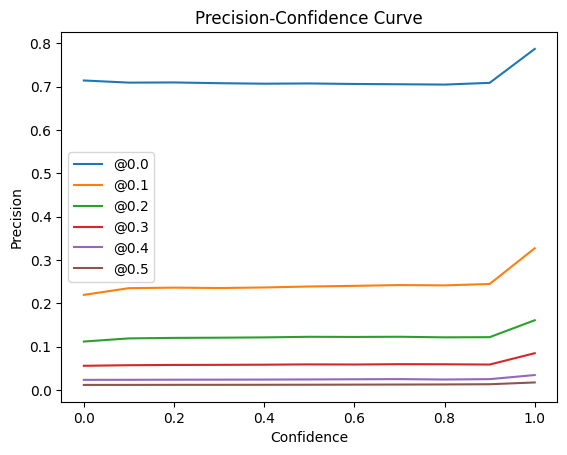

In [54]:
# fazer plot de Precision-Confidence curve
x0 = df0.index
y0 = df0['precision'].to_list()
x1 = df1.index
y1 = df1['precision'].to_list()
x2 = df2.index
y2 = df2['precision'].to_list()
x3 = df3.index
y3 = df3['precision'].to_list()
x4 = df4.index
y4 = df4['precision'].to_list()
x5 = df5.index
y5 = df5['precision'].to_list()

plt.plot(x0, y0, label = '@0.0')
plt.plot(x1, y1, label = '@0.1')
plt.plot(x2, y2, label = '@0.2')
plt.plot(x3, y3, label = '@0.3')
plt.plot(x4, y4, label = '@0.4')
plt.plot(x5, y5, label = '@0.5')

plt.xlabel('Confidence')
plt.ylabel('Precision')
plt.title('Precision-Confidence Curve')
plt.legend()
plt.show()

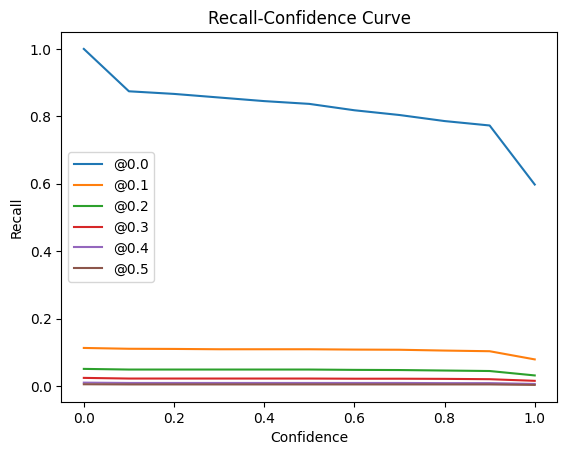

In [55]:
# fazer plot de Recall-Confidence curve
x0 = df0.index
y0 = df0['recall'].to_list()
x1 = df1.index
y1 = df1['recall'].to_list()
x2 = df2.index
y2 = df2['recall'].to_list()
x3 = df3.index
y3 = df3['recall'].to_list()
x4 = df4.index
y4 = df4['recall'].to_list()
x5 = df5.index
y5 = df5['recall'].to_list()

plt.plot(x0, y0, label = '@0.0')
plt.plot(x1, y1, label = '@0.1')
plt.plot(x2, y2, label = '@0.2')
plt.plot(x3, y3, label = '@0.3')
plt.plot(x4, y4, label = '@0.4')
plt.plot(x5, y5, label = '@0.5')

plt.xlabel('Confidence')
plt.ylabel('Recall')
plt.title('Recall-Confidence Curve')
plt.legend()
plt.show()

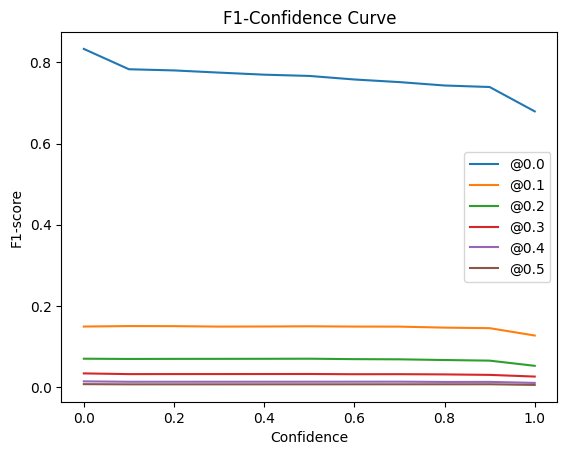

In [56]:
# fazer plot de F1-Confidence curve
x0 = df0.index
y0 = df0['f1-score'].to_list()
x1 = df1.index
y1 = df1['f1-score'].to_list()
x2 = df2.index
y2 = df2['f1-score'].to_list()
x3 = df3.index
y3 = df3['f1-score'].to_list()
x4 = df4.index
y4 = df4['f1-score'].to_list()
x5 = df5.index
y5 = df5['f1-score'].to_list()

plt.plot(x0, y0, label = '@0.0')
plt.plot(x1, y1, label = '@0.1')
plt.plot(x2, y2, label = '@0.2')
plt.plot(x3, y3, label = '@0.3')
plt.plot(x4, y4, label = '@0.4')
plt.plot(x5, y5, label = '@0.5')

plt.xlabel('Confidence')
plt.ylabel('F1-score')
plt.title('F1-Confidence Curve')
plt.legend()
plt.show()

In [60]:
def calculate_average_precision(x, y):

    x = x[:-1]
    y = y[:-1]

    recall_weights = [x[i] - x[i+1] for i in range(len(x)-1)]
    precisionXrw = [recall_weights[i] * y[i] for i in range(len(recall_weights))]

    average_precision = 0
    for i in precisionXrw:
      average_precision += i

    return round(average_precision, 5)

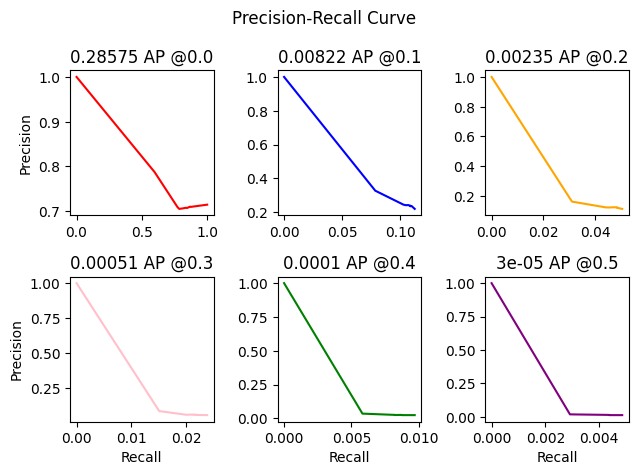

In [124]:
# fazer plot de Precision-Confidence curve, com os valores correspondentes
# da Average Precision (AP) para cada threshold de IoU selecionado

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.suptitle('Precision-Recall Curve')

x0 = df0['recall'].to_list()
x0.append(0)
y0 = df0['precision'].to_list()
y0.append(1)
x1 = df1['recall'].to_list()
x1.append(0)
y1 = df1['precision'].to_list()
y1.append(1)
x2 = df2['recall'].to_list()
x2.append(0)
y2 = df2['precision'].to_list()
y2.append(1)
x3 = df3['recall'].to_list()
x3.append(0)
y3 = df3['precision'].to_list()
y3.append(1)
x4 = df4['recall'].to_list()
x4.append(0)
y4 = df4['precision'].to_list()
y4.append(1)
x5 = df5['recall'].to_list()
x5.append(0)
y5 = df5['precision'].to_list()
y5.append(1)

axes[0,0].plot(x0, y0, color='red')
axes[0,1].plot(x1, y1, color='blue')
axes[0,2].plot(x2, y2, color='orange')
axes[1,0].plot(x3, y3, color='pink')
axes[1,1].plot(x4, y4, color='green')
axes[1,2].plot(x5, y5, color='purple')

axes[0,0].title.set_text(str(calculate_average_precision(x0,y0)) + ' AP @0.0')
axes[0,1].title.set_text(str(calculate_average_precision(x1,y1)) + ' AP @0.1')
axes[0,2].title.set_text(str(calculate_average_precision(x2,y2)) + ' AP @0.2')
axes[1,0].title.set_text(str(calculate_average_precision(x3,y3)) + ' AP @0.3')
axes[1,1].title.set_text(str(calculate_average_precision(x4,y4)) + ' AP @0.4')
axes[1,2].title.set_text(str(calculate_average_precision(x5,y5)) + ' AP @0.5')

axes[1,0].set_xlabel('Recall')
axes[1,1].set_xlabel('Recall')
axes[1,2].set_xlabel('Recall')

axes[0,0].set_ylabel('Precision')
axes[1,0].set_ylabel('Precision')
plt.tight_layout()
plt.show()

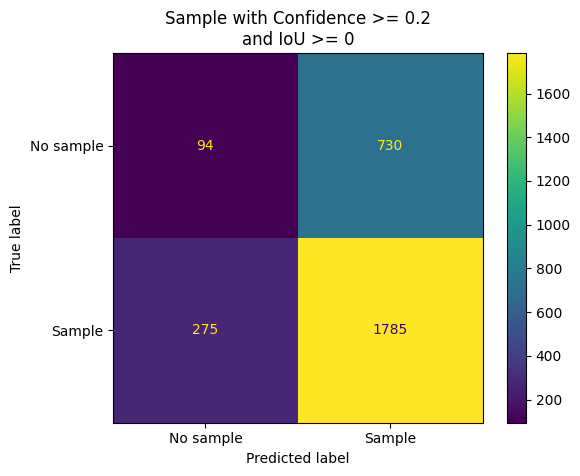


precision = 0.71 
recall = 0.867 
f1-score = 0.78


In [126]:
# dar plot numa Confusion Matrix alterando os valores
# da threshold da confidence e do IoU
conf = 0.2
iou = 0
cm = precision_recall_f1_cm(conf, iou)[1]
cm_plt = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                        display_labels = ['No sample', 'Sample'])
cm_plt.plot()
plt.title('Sample with Confidence >= ' + str(conf) + '\nand IoU >= ' + str(iou))
plt.show()

precision = precision_recall_f1_cm(conf, iou)[0][2]
recall = precision_recall_f1_cm(conf, iou)[0][3]
f1_score = precision_recall_f1_cm(conf, iou)[0][4]

print('\nprecision =', round(precision, 3),
      '\nrecall =', round(recall, 3),
      '\nf1-score =', round(f1_score, 3))

In [69]:
def intersection_over_union(bboxA, bboxB):

    if np.isnan(bboxA[0]) or np.isnan(bboxB[0]):
      return 0

    bboxes = bboxYOLO_to_Albu([bboxA, bboxB])
    bbox1 = bboxes[0]
    bbox2 = bboxes[1]

    # bbox = [xmin, ymin, xmax, ymax]
    xmin = max(bbox1[0], bbox2[0])
    ymin = max(bbox1[1], bbox2[1])
    xmax = min(bbox1[2], bbox2[2])
    ymax = min(bbox1[3], bbox2[3])

    intersection_width = xmax - xmin
    intersection_height = ymax - ymin

    if intersection_width <= 0 or intersection_height <= 0:
      return 0

    intersection_area = intersection_width * intersection_height

    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = bbox1_area + bbox2_area - intersection_area

    IoU = round(intersection_area / union_area, 2)

    return IoU

In [70]:
print(' - for y_test_detection and y_pred_detection:'
      '\n mean % of the area intersected in all intersections:', iou_info(y_test_regression, y_pred_regression)[0],
      '\n number of intersections:', iou_info(y_test_regression, y_pred_regression)[1],
      '\n percentage of intersections:', iou_info(y_test_regression, y_pred_regression)[2],
      '\n indexes of images with intersections:', iou_info(y_test_regression, y_pred_regression)[3])

 - for y_test_detection and y_pred_detection:
 mean % of the area intersected in all intersections: 14.93403693931398 
 number of intersections: 379 
 percentage of intersections: 13.14147018030513 
 indexes of images with intersections: [141, 142, 143, 185, 186, 187, 188, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 254, 255, 256, 257, 258, 259, 260, 471, 501, 502, 503, 504, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 538, 540, 720, 721, 722, 723, 747, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 777, 788, 789, 790, 791, 792, 793, 794, 795, 860, 934, 935, 936, 998, 999, 1000, 1001, 1002, 1003, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1038, 1039, 1040, 1041, 1042, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 109

In [71]:
indexes_positives = precision_recall_f1_cm(0.3, 0)[2]
confidence_scores = precision_recall_f1_cm(0.3, 0)[3]

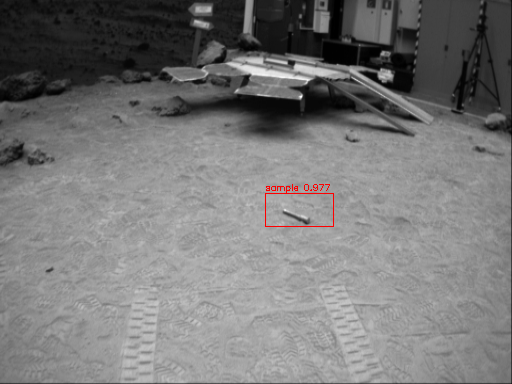

In [72]:
index = indexes_positives[500]
show_image_bbox(X_test_reshaped[index],
                y_pred_regression[index],
                confidence_scores[index], 'test1.png')

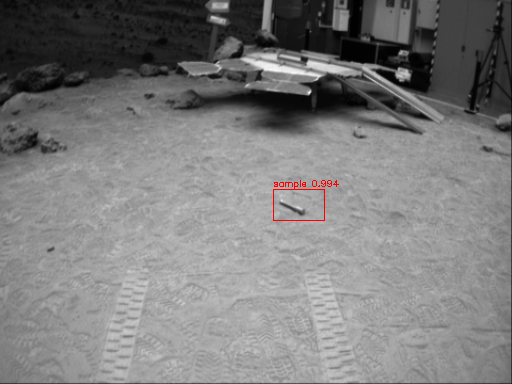

In [73]:
index = indexes_positives[750]
show_image_bbox(X_test_reshaped[index],
                y_pred_regression[index],
                confidence_scores[index], 'test2.png')

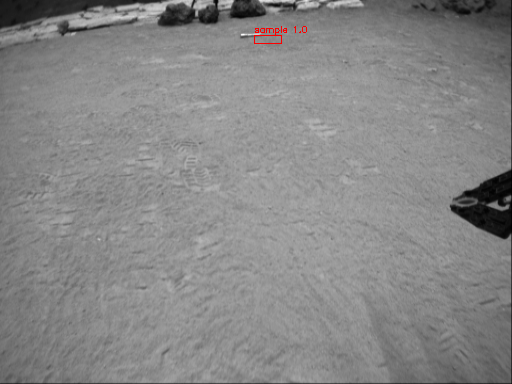

In [132]:
index = indexes_positives[1000]
show_image_bbox(X_test_reshaped[index],
                y_pred_regression[index],
                confidence_scores[index], 'test3.png')

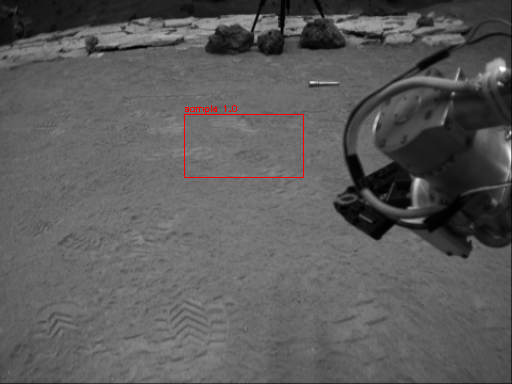

In [130]:
index = indexes_positives[1500]
show_image_bbox(X_test_reshaped[index],
                y_pred_regression[index],
                confidence_scores[index], 'test4.png')